<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Import packages</h1>

In [1]:
import easydict
import os
import numpy as np
import math
import matplotlib.pyplot as plt
 
import torchvision.transforms as transforms
from torchvision.utils import save_image
 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
 
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
 
import pandas as pd
from tqdm import tqdm 
import time
 
from random import randint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from matplotlib import rc
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from scipy.interpolate import interp1d

# Plot graph on the jupyter notebook outupt shell.
%matplotlib inline
 
import copy as cp
from IPython.display import clear_output
 
# Define common arguments 
arg = easydict.EasyDict({ "n_epochs": 15000,        # No. of epochs
                          "batch_size": 5000,       # Batch size
                          "lr": 1e-3,               # Learning rate
                          "b1": 0.9,                # optimizer parameter 1
                          "b2": 0.999,              # optimizer parameter 2
                          "weight_decay": 0.0001,   # weight decay
                          "input_dim": 40,          # Inintial robot state 
                          "output_dim": 40,         # Robot state dimension for each node fo output trajectory 
                          "goal_dim": 6,            # Goal base body pose dimension
                          "n_cpu": 8,               # Number of CPU cores to be used
                          "re_size": 64,            # Image (height map) size
                          "z_dim": 128,             # Terrain encoder latent space dimension
                          "sample_interval": 400 }) # Output visualization interval
print(arg)
 
cuda = True if torch.cuda.is_available() else False             # Cehck CUDA availibility
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor  # If CUDA is usable, tensor will be uploaded into GPU, unless ulpoaded into CPU.

use_cuda = True
if torch.cuda.is_available():
  device = torch.device("cuda")

  

{'n_epochs': 15000, 'batch_size': 5000, 'lr': 0.001, 'b1': 0.9, 'b2': 0.999, 'weight_decay': 0.0001, 'input_dim': 40, 'output_dim': 40, 'goal_dim': 6, 'n_cpu': 8, 're_size': 64, 'z_dim': 128, 'sample_interval': 400}


<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Data organization</h1>

In [2]:
# Place Path data into dataloader
class GenDataset(Dataset):
 
  def __init__(self, PathData, TerrainData, transform=None):
      self.dataP = PathData.float()     # Path data
      self.dataT = TerrainData.float()  # Terrain data
      self.transform = transform        # Custom transform for heightmap
      
  def __getitem__(self, index):
      dataP = self.dataP[index]
      dataT = self.dataT[index]
      if self.transform:
            dataT = self.transform(dataT)
      return index, dataP, dataT
 
  def __len__(self):
      return len(self.dataP)

In [3]:
'''
* Write the correct path for your environment (all path). It is an absolute path.
** For the training efficiency, we pre-extracted the latent sapce data from terrian heightmap dataset.
  So the 'TESTterrain' contains the latent space, not the heightmap of each terrain.
'''
      
# Load data
PATH='/content/drive/MyDrive/Colab Notebooks'
PathsData = torch.tensor(np.load(PATH+'/data/Paths.npy'))#[:-5999]
TESTterrain = torch.tensor(np.load(PATH+'/data/TerrainLatent.npy'))#[:-5999]
pData = cp.deepcopy(PathsData)
tData = cp.deepcopy(TESTterrain)

# Parameters
dt=2  # Node interval: 0.02 sec
NUMval = 3000 # Test dataset size
MaxPathNum = np.shape(pData)[0]     # Number of the paths in training dataset
MaxSampleNum = np.shape(pData)[1]   # Number of nodes in each path
Path_dim = np.shape(pData)[2]       # Dimension of each node (=40)
seq_size = (MaxSampleNum-1)//dt # Trajectory node num, 100

# shuffle dataset
shuffleDataset = GenDataset(pData, tData, transform=None)                             # Generate a dataset of (path, terrain), with no transform(since we use latent sapce directly).
shuffleDataloader = DataLoader(shuffleDataset,batch_size=MaxPathNum,shuffle=True)     # Generate a dataset loader for training
_, PathsData, TESTterrain = next(iter(shuffleDataloader))

# Path data
Paths = cp.deepcopy(PathsData[NUMval:,:,:])
Paths_test = cp.deepcopy(PathsData[:NUMval,:,:])
Paths_ori = cp.deepcopy(Paths)
Paths_test_ori = cp.deepcopy(Paths_test)

# Terrain data
Terrains = cp.deepcopy(TESTterrain[NUMval:,:])
Terrains_test = cp.deepcopy(TESTterrain[:NUMval,:])

NameSpace = {0:'baseX',   1:'baseY',    2:'baseZ', 
             3:'baseR',   4:'baseP',    5:'baseYaw', 
             6:'baseVx',  7:'baseVy',   8:'baseVz', 
             9:'baseVr',  10:'baseVp',  11:'baseVyaw',
             12:'LFx',    13:'LFy',     14:'LFz',
             15:'RFx',    16:'RFy',     17:'RFz',
             18:'LHx',    19:'LHy',     20:'LHz',
             21:'RHx',    22:'RHy',     23:'RHz',
             24:'LFfx',   25:'LFfy',    26:'LFfz',
             27:'RFfx',   28:'RFfy',    29:'RFfz',
             30:'LHfx',   31:'LHfy',    32:'LHfz',
             33:'RHfx',   34:'RHfy',    35:'RHfz',}
Scaler = 100.0
zDomain=[-26,-23,-20,-17,-14,-11,-8,-5]
FOOT=[0,3,6,9]

Paths[:,:,-16:-4] = Paths_ori[:,:,-16:-4]/Scaler
Paths_test[:,:,-16:-4] = Paths_test_ori[:,:,-16:-4]/Scaler

DeepQMPdataset = GenDataset(Paths, Terrains, transform=None)                             # Generate a dataset of (path, terrain), with no transform(since we use latent sapce directly).
DeepQMPdata_loader = DataLoader(DeepQMPdataset,batch_size=arg.batch_size,shuffle=True)   # Generate a dataset loader for training

_, path, img = next(iter(DeepQMPdata_loader))

del PathsData,TESTterrain

In [4]:
# Custom image visualization function. Input must be 4d.
def show(img,nrow=3):
  # img = img*std + mean
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('on')
  plt.show()
  
# Interpolation for output trajectory
def interNodes(Nodes, batch_size, seq_size=MaxSampleNum//dt):
  data=Nodes.view(1,batch_size,seq_size,Path_dim).permute(1,3,0,2)

  InterState=F.interpolate(data[:,:-4,:,:], [1,MaxSampleNum], mode='bilinear') # 4D 1-dim height form
  InterContact=F.interpolate(data[:,-4:,:,:], [1,MaxSampleNum], mode='nearest') # 4D 1-dim height form
  Inter = torch.cat([InterState, InterContact], dim=1)

  return Inter.permute(2,0,3,1).view(batch_size,MaxSampleNum,Path_dim)

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Terrain encoder definition</h1>

In [5]:
# Terrain encoder structure. In this code, we are not using this.
class TeerainEncoder(nn.Module):
  def __init__(self): 
        super(TeerainEncoder, self).__init__()
        latent_dim = arg.z_dim
        self.latent_dim = latent_dim
        self.im_channels = in_channels = 1

        modules = []
        hidden_dims = [32, 64, 64, 128, 256]
        self.hidden_dims = hidden_dims.copy()

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.LatentSpace = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                                        nn.ConvTranspose2d(hidden_dims[-1],
                                                            hidden_dims[-1],
                                                            kernel_size=3,
                                                            stride=2,
                                                            padding=1,
                                                            output_padding=1),
                                        nn.BatchNorm2d(hidden_dims[-1]),
                                        nn.LeakyReLU(),
                                        nn.Conv2d(hidden_dims[-1], out_channels= self.im_channels,
                                                  kernel_size= 3, padding= 1),
                                        nn.Tanh())

  def encode(self, input: Tensor):
      result = self.encoder(input)
      result = torch.flatten(result, start_dim=1)
      latent = self.LatentSpace(result)

      return latent

  def decode(self, z: Tensor):
      result = self.decoder_input(z)
      result = result.view(-1, self.hidden_dims[-1], 2, 2)
      result = self.decoder(result)
      result = self.final_layer(result)

      return result

  def forward(self, z_in, input: Tensor, **kwargs):
      z = self.encode(input)
      recon = self.decode(z_in)
      return  [recon, input, z]


<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Planner Network definition</h1>

In [6]:
# Swish activation function
class swish(nn.Module): 
  def __init__(self): 
    super(swish, self).__init__()
  def forward(self, X):
    return X * torch.sigmoid(X) 

# Mish activation function
class mish(nn.Module): 
  def __init__(self): 
    super(mish, self).__init__()
  def forward(self, X):
    return X * torch.tanh(F.softplus(X))

class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size
    def forward(self, tensor):
        return tensor.view(self.size)

# Trajectory generation network
class DeepQMP(nn.Module): # torch.nn.Module을 상속받는 파이썬 클래스
    def __init__(self): 
        super(DeepQMP, self).__init__()
        input_dim=arg.input_dim   # Initial robot state, 40
        goal_dim=arg.goal_dim     # Goal base body pose, 6
        output_dim=arg.output_dim # Each node's dimension of output trajectory, 40
 
        input_dim=arg.input_dim + arg.goal_dim  # Input dimension for state feature extraction, 46
 
        alpha=0.01  # Leakyrelu slope
 
        # State feature extraction (CNN structure)
        ch1 = 24  # Number of low-level feature channel

        # Spatial feature extraction
        self.ConvReal = nn.Sequential(
                                              nn.Conv2d(1, ch1, (3, 1), stride=(3,1)),
                                              nn.BatchNorm2d(ch1),
                                              # nn.LeakyReLU(alpha, inplace=True),
                                              mish(),
                                              # output : 14 x 24
                                  )
        # Contact feature extraction
        self.ConvBin = nn.Sequential(
                                              nn.Conv2d(1, ch1, (4, 1), stride=1),
                                              nn.BatchNorm2d(ch1),
                                              mish(),
                                              # output : 1 x 24
                                  )
        # Environmental feature extraction
        self.ConvEnv = nn.Sequential(
                                              nn.Conv2d(1, ch1, (5, 1), stride=(3,1)),
                                              nn.BatchNorm2d(ch1),
                                              mish(),
                                              # output : 42 x 24
                                    )
        # State feature extraction channel sizes
        ch2 = 1
        ch3 = 8
        ch4 = 16
        ch5 = 32
        # Extracted state feature size  featW x featH x ch5. This is inserted into MLP layers
        featW = 13
        featH = 2
        sub_input_dim = featW * featH * ch5
        self.StateFeatures = nn.Sequential(
                                              nn.Conv2d(1, ch2, (3, 3), stride=3),
                                              nn.BatchNorm2d(ch2),
                                              mish(),
                                              nn.Conv2d(ch2, ch3, (3, 3), stride=1),
                                              nn.BatchNorm2d(ch3),
                                              mish(),
                                              nn.Conv2d(ch3, ch4, (3, 3), stride=1),
                                              nn.BatchNorm2d(ch4),
                                              mish(),
                                              nn.Conv2d(ch4, ch5, (3, 3), stride=1),
                                              nn.BatchNorm2d(ch5),
                                              # mish(),
                                              nn.Flatten(),
                                              nn.Linear(sub_input_dim, output_dim, bias=True),
                                              nn.BatchNorm1d(output_dim),
                                              mish(),
                                            )
        
        # Trajectory generation (MLP structure)
        dslayer1 = 64  
        dslayer2 = 128
        dslayer3 = 256  
        self.CNN_DenseNet = nn.Sequential(
                                                nn.Linear(output_dim, dslayer1, bias=True),
                                                nn.BatchNorm1d(dslayer1),
                                                mish(),
                                           
                                                nn.Linear(dslayer1, dslayer2, bias=True),     
                                                nn.BatchNorm1d(dslayer2),
                                                mish(),
                                           
                                                nn.Linear(dslayer2, dslayer3, bias=True),   
                                                nn.BatchNorm1d(dslayer3),
                                                mish(),
                                            )
        # Desired number of node of output trajectory, 100
        self.PathLen = (MaxSampleNum-1)//dt
        self.output_dim = output_dim
        self.GenPath = nn.Sequential(
                                                nn.Linear(dslayer3, self.PathLen*output_dim),
                                      )
 
    def forward(self, X, Terrain):
        # HnC : Hiddne and Cell state
        # X     = (seq, batch, dim)
        # CnnX  = (batch, ch, dim, seq)
        # lstmX = (seq, batch, dim)
        # mlpX  = (batch, dim)
 
        # CNN - State features
        CnnX = torch.cat([X[:,:-10], X[:,-6:]], dim=1)
        CnnX = CnnX.reshape(CnnX.shape[0], 1, CnnX.shape[1], 1)
        cnnReal_out = self.ConvReal(CnnX)
 
        CnnX = X[:,-10:-6]
        CnnX = CnnX.reshape(CnnX.shape[0], 1, CnnX.shape[1], 1)
        cnnBin_out = self.ConvBin(CnnX)     

        CnnX = Terrain
        CnnX = CnnX.reshape(CnnX.shape[0], 1, CnnX.shape[1], 1)
        cnnEnv_out = self.ConvEnv(CnnX)       
 
        CnnX = torch.cat([cnnReal_out, cnnBin_out], dim=2)
        CnnX = torch.cat([CnnX, cnnEnv_out], dim=2)
        CONVoutput = self.StateFeatures(CnnX.permute(0,3,1,2))
        
        # MLP 
        mlpX = CONVoutput# + X[:,:-6]
        MLPout = self.CNN_DenseNet(mlpX)

        # Generate path
        FullPath = self.GenPath(MLPout).view(-1,self.PathLen,self.output_dim)
        FullPath[:,:,-4:] = torch.sigmoid(FullPath[:,:,-4:])
        return FullPath

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Loss function</h1>

In [16]:
# Loss
L1_loss = nn.L1Loss()
L2_loss = nn.MSELoss()
Huber_loss = nn.SmoothL1Loss()
BCE_Loss = torch.nn.BCELoss()

# Model regularization (L1, LASSO)
def L1_regularization(model):
  regularization_loss=0
  for param in model.parameters():
    regularization_loss += torch.sum(torch.abs(param))
    
  return regularization_loss
 
# Model regularization (L2, Ridge)
def L2_regularization(model):
  regularization_loss=0
  for param in model.parameters():
    regularization_loss += param.norm(2)**2
    
  return regularization_loss

# Cutoff function for contact information
def cutoff(X, sv=0.5):
    return torch.tensor(X>sv, dtype=torch.float)

# Plot 3-axis losses: Total loss, BCE loss for contact information, Regularization loss
def LossPlot(train_loss, val_loss, reg_loss, valstep, title='LearningLoss'):
    fig = plt.figure()
    fig.suptitle("Train loss : "+str(train_loss[-1]))
    offset = 50
    
    ax1 = host_subplot(111, axes_class=AA.Axes)
    bceloss,=ax1.plot(valstep, val_loss, color='g', label='Validation loss')
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Validation loss")
    ax1.yaxis.label.set_color('g')
    
    ax2 = ax1.twinx().twiny()
    # new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    # ax2.axis["right"] = new_fixed_axis(loc="right", axes=ax2, offset=(0, 0))
    loss,=ax2.plot(train_loss, color='b', label='Train loss')
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Losses")
    ax2.yaxis.label.set_color('b')
    
    ax3 = ax2.twinx()
    # new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
    # ax3.axis["right"] = new_fixed_axis(loc="right", axes=ax3, offset=(offset, 0))
    regloss,=ax3.plot(reg_loss, color='r', label='Regularazation loss')
    ax3.set_xlabel("Steps")
    ax3.set_ylabel("Regularization")
    ax3.yaxis.label.set_color('r')
 
    graphs=[bceloss, loss, regloss]
    ax3.legend(graphs, [curve.get_label() for curve in graphs])
    plt.show()
    fig.tight_layout()
    fig.savefig(PATH+'/graph/'+title+'.png',dpi=100)

# Custom loss function: Loss = (domain-wise MSE loss) + (contact BCE loss) + (model regularization)
def Convergence_Loss(Pred, Tagt): 
    lambdaExp = torch.ones(36)
    lambdaRecon = 1
    lambdaBCE = 0.5
    lambdaReg = 0.02
    labdaGoal = 0
    # labdaGoal = 5
    lambdaKin = 1
    lambdaCon = 1
            
    '''
      COST
    '''
    # State loss (domain-wise)
    Lexp=[]
    # Lexp.append( lambdaExp[0]*L2_loss(Pred[:,:,:3], Tagt[:,:,:3]) )      # Xb
    # Lexp.append( lambdaExp[1]*L2_loss(Pred[:,:,3:6], Tagt[:,:,3:6]) )    # Theta_b
    # Lexp.append( lambdaExp[2]*L2_loss(Pred[:,:,6:9], Tagt[:,:,6:9]) )    # Vb
    # Lexp.append( lambdaExp[3]*L2_loss(Pred[:,:,9:12], Tagt[:,:,9:12]) )  # Omega_b
    # Lexp.append( lambdaExp[4]*L2_loss(Pred[:,:,12:24], Tagt[:,:,12:24]) )# Pi 
    # Lexp.append( lambdaExp[5]*L2_loss(Pred[:,:,24:36], Tagt[:,:,24:36]) )# Fi 
    for dom in range(36):
      Lexp.append( lambdaExp[dom]*L2_loss(Pred[:,:,dom], Tagt[:,:,dom]) )
    # Contact loss
    Lbce  = BCE_Loss(Pred[:,:,-4:], Tagt[:,:,-4:])
    # Regularization & goal loss
    Lreg  = L2_regularization(Estimator)/(2*Pred.shape[0])
    Lgoal = L2_loss(Pred[:,-1,:], Tagt[:,-1,:])# Just for checking, not included in loss function
 
    print('Ldim  : ',', '.join('{0:5.5f}'.format(k[-1]) for k in enumerate(torch.tensor(Lexp).tolist())))
    print('Lexp  : ',format(sum(Lexp).item(), '.5f'))
    print('Lgoal : ',format(Lgoal.item(), '.5f'))
    print('Lbce  : ',format(Lbce.item(), '.5f'))
    print('Lreg  : ',format(Lreg.item(), '.5f'))
 
    return lambdaRecon*(sum(Lexp)/len(Lexp)) + lambdaBCE*Lbce + lambdaReg*Lreg


<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Network definition</h1>

In [8]:
# Define Network model
Estimator = DeepQMP()
Terrain_Info = TeerainEncoder()
# Load model on GPU
if cuda:
    Estimator.cuda()
    Terrain_Info.cuda()
 
# optimizer (AdamW optimizer with cosine anealing scheduler)
optimizer = torch.optim.AdamW(Estimator.parameters(), lr=arg.lr, betas=(arg.b1, arg.b2), weight_decay=arg.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 2000)

In [9]:
# Load CHECK POINT to continue the learning...
paramsE = torch.load(PATH+"/model/QuadNet.tar", map_location = "cpu")
# paramsE = torch.load(PATH+"/model/QuadNet_.tar", map_location = "cpu")
Estimator.load_state_dict(paramsE['model_state_dict'])

<All keys matched successfully>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Training sequence</h1>

In [17]:
# Learning loop 
Estimator.train()   # Set the trajectory generator train mode

hypothesis=[];prediction=[]
train_loss=[];reg_loss=[];bce_loss=[];val_loss=[];valSteps=[]
valStep=0

# Learning loop
for epoch in tqdm(range(arg.n_epochs), position=0, leave=True):
    bcnt=0
    lossTr=0;  lossBCE=0;  lossREG=0;  lossFeat=0;  lossReal=0;  lossFake=0;  lossVal=0;  
    # Load batch 
    for batch_idx, Data in enumerate(DeepQMPdata_loader):
      # Data consists of (samples' index, ground truth trajectory, terrain)
      bcnt+=1
      batch_size = Data[0].shape[0]
      refPath = Variable(np.transpose(Data[1].view(batch_size, -1, Path_dim),(1,0,2)).type(Tensor))

      # Clear ipython output
      clear_output(wait=True)
      
      # ---------------------
      #  Train Path Generator
      # ---------------------
      optimizer.zero_grad()

      # Initial state
      States = refPath[0,:,:].view( -1, Path_dim)
      # Goal base body pose
      Goals = refPath[-1,:,0:6].view(-1,6)
    
      Xdata = torch.cat([States, Goals],dim=1)
      hypothesis = Estimator(Xdata, Data[-1].type(Tensor)) # Xdata : (seq, batch, dim), concated with goal
      hypothesis[:,0] = States

      # Interpolate 
      Predict = interNodes(hypothesis, batch_size, seq_size)

      # Sample reference
      TargetNodes = refPath[:-1,:,:].permute(1,0,2)[:,0::dt,:]
      TargetNodes[:,-1,:] = refPath[-1,:,:]
      Target = interNodes(TargetNodes, batch_size, seq_size)
      print("Waypoint Loss");    Waypointloss = Convergence_Loss(hypothesis,TargetNodes)
      # print("\nFullpath Loss");  FullPathloss = Convergence_Loss(Predict,Target)
      trloss = Waypointloss

      # Optimize
      trloss.backward()
      optimizer.step()
      scheduler.step()

      lossTr+=trloss.item()
      lossREG+=(L2_regularization(Estimator)/(2*Predict.shape[0])).item()
      lossBCE+=(BCE_Loss((Predict[:,:,-4:]), Target[:,:,-4:])).item()

      print(
            "[Epoch %d/%d] [Batch %d/%d] [Path loss: %f]"
            % (epoch, arg.n_epochs, batch_idx % len(DeepQMPdata_loader), len(DeepQMPdata_loader), trloss.item())
        )

      # Save checkpoint
      if batch_idx%2 == 0:
        torch.save({'model_state_dict': Estimator.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': trloss},
                  PATH+"/model/QuadNet.tar", pickle_protocol = 4)
      else:
        torch.save({'model_state_dict': Estimator.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': trloss},
                  PATH+"/model/QuadNet_.tar", pickle_protocol = 4)

    # Save train loss
    train_loss.append(lossTr/bcnt)
    reg_loss.append(lossREG/bcnt)
    bce_loss.append(lossBCE/bcnt)

    if epoch%20 == 0:
      # Plot path
      num_sam = 1
      fig = plt.figure()
      plt.scatter(refPath[:,0:num_sam,0].cpu(), refPath[:,0:num_sam,1].cpu(),s=120.0 , c='red', edgecolors='black', label='Target')
      plt.scatter(refPath[-1,0:num_sam,0].cpu(), refPath[-1,0:num_sam,1].cpu(),s=50.0 , c='grey', edgecolors='black', label='Goals')
      plt.scatter(Predict[0:num_sam,:,0].cpu().detach().numpy(), Predict[0:num_sam,:,1].cpu().detach().numpy(),s=80.0 , c='lime', edgecolors='black', alpha=0.6, label='Predict(Path)')
      plt.scatter(TargetNodes[0:num_sam,:,0].cpu(), TargetNodes[0:num_sam,:,1].cpu(),s=120.0 , c='aqua', edgecolors='black', label='Target(Nodes)')
      plt.scatter(hypothesis[0:num_sam,:,0].cpu().detach().numpy(), hypothesis[0:num_sam,:,1].cpu().detach().numpy(),s=120.0 , c='orange', edgecolors='black', alpha=0.8, label='Predict(Node)')
      plt.scatter(States[0:num_sam,0].cpu(), States[0:num_sam,1].cpu(),s=120.0, c='yellow', edgecolors='black', label='Input')
      plt.legend(fontsize='x-large')
      plt.show()
      fig.tight_layout()
      fig.savefig(PATH+'/graph/BasePath.png',dpi=100)
      
      # Validation loss
      Estimator.eval()
      valPaths = cp.deepcopy(Paths_test)
      valStates = valPaths[:,0,:].view( -1, Path_dim)
      valGoals = valPaths[:,-1,0:6].view(-1,6)
      valdata = torch.cat([valStates, valGoals],dim=1)
      validation = Estimator(valdata.type(Tensor), Terrains_test.type(Tensor))
      validation[:,0] = valStates.type(Tensor)
      valNodes = valPaths[:,:-1,:][:,0::dt,:]
      valNodes[:,-1,:] = valPaths[:,-1,:]
      print("Validation Loss");    
      valloss = Convergence_Loss(validation.detach(),valNodes.type(Tensor).detach())
      lossVal = valloss.item()
      valStep += 1
      val_loss.append(lossVal)
      valSteps.append(valStep)
      Estimator.train()

      # Plot loss curves
      LossPlot(train_loss, val_loss, reg_loss, valSteps) 
      

print("Final loss : ",trloss.data.item())
t=time.localtime(time.time())
plt.title("Train loss : "+str(trloss.cpu().detach().numpy()))
plt.plot(train_loss)
plt.savefig(PATH+'/graph/LearningLoss_'+str(t.tm_year)+str(t.tm_mon)+str(t.tm_mday)+str(t.tm_hour)+str(t.tm_min)+'.png',dpi=100)
# plt.show()
 
# Save model & parameters
torch.save({'model_state_dict': Estimator.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': trloss},
            PATH+"/model/QuadNet"+str(t.tm_year)+str(t.tm_mon)+str(t.tm_mday)+str(t.tm_hour)+str(t.tm_min)+".tar", pickle_protocol = 4)

Waypoint Loss
Ldim  :  0.00374, 0.00225, 0.00990, 0.00447, 0.00335, 0.01159, 0.03299, 0.01791, 0.03388, 0.16692, 0.14966, 0.24585, 0.00457, 0.00297, 0.00312, 0.00447, 0.00316, 0.00338, 0.00473, 0.00337, 0.00239, 0.00480, 0.00302, 0.00284, 0.04789, 0.04217, 0.04037, 0.03475, 0.02118, 0.02834, 0.03711, 0.02083, 0.02808, 0.04422, 0.03922, 0.04049
Lexp  :  1.14999
Lgoal :  0.01759
Lbce  :  0.00843
Lreg  :  0.40850


KeyboardInterrupt: ignored

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Test scene</h1>

3190


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


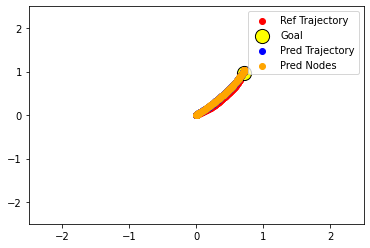

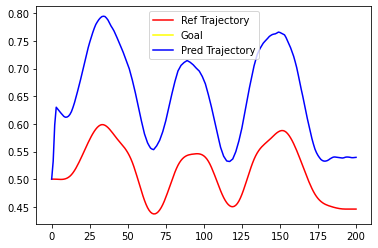

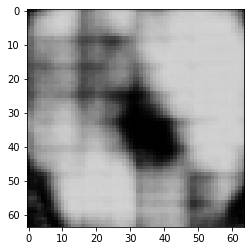

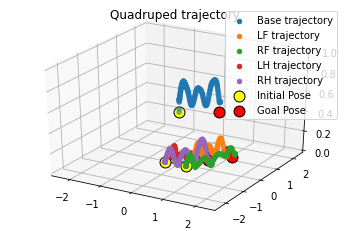

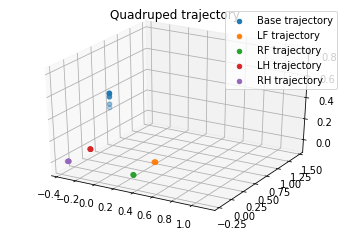

In [19]:
# Load trained trajectory generation network with evaluation mode
params = torch.load(PATH+"/model/QuadNet.tar", map_location = "cpu")
Estimator.load_state_dict(params['model_state_dict'])
Estimator.eval()

# # Load trained terrain encoder with evaluation mode
Terrainparams = torch.load(PATH+"/model/TerrainEncoder_64x64.tar", map_location = "cpu")
Terrain_Info.load_state_dict(Terrainparams['model_state_dict'])
Terrain_Info.eval()

Dataset = Paths
DatasetT = Terrains
# Dataset = Paths_test
# DatasetT = Terrains_test
index = randint(0, Dataset.shape[0])
# index=12141
num=index
print(index)

# Initial state
States = Dataset[num,0,:].view(1,-1).type(Tensor)
# Goal base body pose
Goals = Dataset[num,-1,0:6].view(1,6).type(Tensor)
XnG = torch.cat([States, Goals],dim=1).type(Tensor)
TerrainLatent=DatasetT[index].view(1,-1).type(Tensor)
motion = Estimator(XnG, TerrainLatent)
motion = motion.cpu().detach()
index=0

# Interpolate
seq_size = (MaxSampleNum-1)//dt
Nodes = cp.deepcopy(motion)
Nodes[:,0] = States
Predict = interNodes(Nodes, motion.shape[0], seq_size)
motion = Predict

#Post processing
# motion[0,:,:-4] = motion[0,:,:-4]*scale
motion[0,:,-4:]  = cutoff(motion[0,:,-4:]) 
 
fig = plt.figure()
# XY plot
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.scatter(Dataset[num,:,0], Dataset[num,:,1], label='Ref Trajectory', color='red')
plt.scatter(Goals[0,0].cpu(), Goals[0,1].cpu(), label='Goal', color='yellow', edgecolor='black', s=200)
plt.scatter(motion[index,:,0], motion[index,:,1], label='Pred Trajectory', color='blue')
plt.scatter(Nodes[index,:,0], Nodes[index,:,1], label='Pred Nodes', color='Orange')
plt.legend()
plt.show()

# Height (base position z-axis)
plt.plot(Dataset[num,:,2], label='Ref Trajectory', color='red')
plt.plot(Goals[0,2].cpu(), label='Goal', color='yellow')
plt.plot(motion[index,:,2], label='Pred Trajectory', color='blue')
plt.legend()
plt.show()

# Reconstruct original map
out=Terrain_Info(TerrainLatent,torch.ones(1,1,arg.re_size,arg.re_size).type(Tensor))
show(out[0].detach().cpu())

# Plot trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
ax.set_xlim3d(-2.5,2.5)
ax.set_ylim3d(-2.5,2.5)
ax.set_zlim3d(0.,1)
body=ax.scatter(motion[index,:,0], motion[index,:,1], motion[index,:,2], label='Base trajectory')
LF=ax.scatter(motion[index,:,12], motion[index,:,13], motion[index,:,14], label='LF trajectory')
RF=ax.scatter(motion[index,:,15], motion[index,:,16], motion[index,:,17], label='RF trajectory')
LH=ax.scatter(motion[index,:,18], motion[index,:,19], motion[index,:,20], label='LH trajectory')
RH=ax.scatter(motion[index,:,21], motion[index,:,22], motion[index,:,23], label='RH trajectory')
 
body=ax.scatter(Dataset[num,0,0], Dataset[num,0,1], Dataset[num,0,2], label='Initial Pose', color='yellow', edgecolor='black', s=120)
LF=ax.scatter(Dataset[num,0,12], Dataset[num,0,13], Dataset[num,0,14], color='yellow', edgecolor='black', s=120)
RF=ax.scatter(Dataset[num,0,15], Dataset[num,0,16], Dataset[num,0,17], color='yellow', edgecolor='black', s=120)
LH=ax.scatter(Dataset[num,0,18], Dataset[num,0,19], Dataset[num,0,20], color='yellow', edgecolor='black', s=120)
RH=ax.scatter(Dataset[num,0,21], Dataset[num,0,22], Dataset[num,0,23], color='yellow', edgecolor='black', s=120)
 
body=ax.scatter(Dataset[num,-1,0], Dataset[num,-1,1], Dataset[num,-1,2], label='Goal Pose', color='red', edgecolor='black', s=120)
LF=ax.scatter(Dataset[num,-1,12], Dataset[num,-1,13], Dataset[num,-1,14], color='red', edgecolor='black', s=120)
RF=ax.scatter(Dataset[num,-1,15], Dataset[num,-1,16], Dataset[num,-1,17], color='red', edgecolor='black', s=120)
LH=ax.scatter(Dataset[num,-1,18], Dataset[num,-1,19], Dataset[num,-1,20], color='red', edgecolor='black', s=120)
RH=ax.scatter(Dataset[num,-1,21], Dataset[num,-1,22], Dataset[num,-1,23], color='red', edgecolor='black', s=120)
ax.legend()
plt.show()
 
# Animation
motion=motion[:,:-1,:]
speed=5
nodes = MaxSampleNum//speed
steps = np.array([np.ones(speed)*i for i in range(nodes)]).flatten()
df_body = pd.DataFrame({"time": steps ,"x" : motion[index,:,0], "y" : motion[index,:,1], "z" : motion[index,:,2]})
df_LF = pd.DataFrame({"time": steps ,"x" : motion[index,:,12], "y" : motion[index,:,13], "z" : motion[index,:,14]})
df_RF = pd.DataFrame({"time": steps ,"x" : motion[index,:,15], "y" : motion[index,:,16], "z" : motion[index,:,17]})
df_LH = pd.DataFrame({"time": steps ,"x" : motion[index,:,18], "y" : motion[index,:,19], "z" : motion[index,:,20]})
df_RH = pd.DataFrame({"time": steps ,"x" : motion[index,:,21], "y" : motion[index,:,22], "z" : motion[index,:,23]})
 
def update_graph(cnt):
  # Body
  data=df_body[df_body['time']==cnt]
  body._offsets3d = (data.x, data.y, data.z)
  # LF
  data=df_LF[df_LF['time']==cnt]
  LF._offsets3d = (data.x, data.y, data.z)
  # RF
  data=df_RF[df_RF['time']==cnt]
  RF._offsets3d = (data.x, data.y, data.z)
  # LH
  data=df_LH[df_LH['time']==cnt]
  LH._offsets3d = (data.x, data.y, data.z)
  # RH
  data=df_RH[df_RH['time']==cnt]
  RH._offsets3d = (data.x, data.y, data.z)
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
body=ax.scatter(motion[index,:,0], motion[index,:,1], motion[index,:,2], label='Base trajectory')
LF=ax.scatter(motion[index,:,12], motion[index,:,13], motion[index,:,14], label='LF trajectory')
RF=ax.scatter(motion[index,:,15], motion[index,:,16], motion[index,:,17], label='RF trajectory')
LH=ax.scatter(motion[index,:,18], motion[index,:,19], motion[index,:,20], label='LH trajectory')
RH=ax.scatter(motion[index,:,21], motion[index,:,22], motion[index,:,23], label='RH trajectory')
ax.legend()
 
ani = animation.FuncAnimation(fig, update_graph, MaxSampleNum//speed, interval=200, blit=False)
rc('animation', html='html5')
 
ani

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


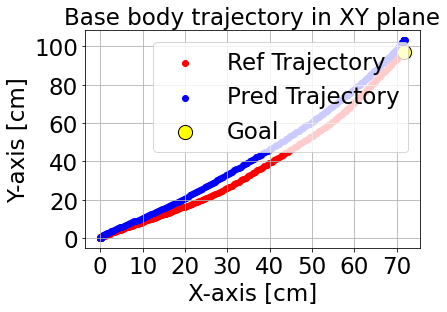

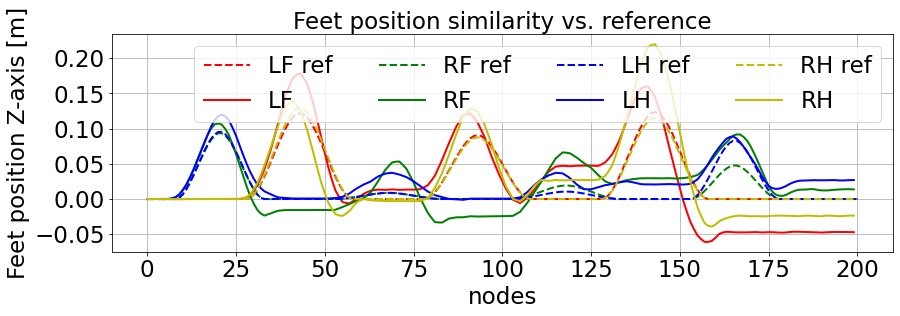

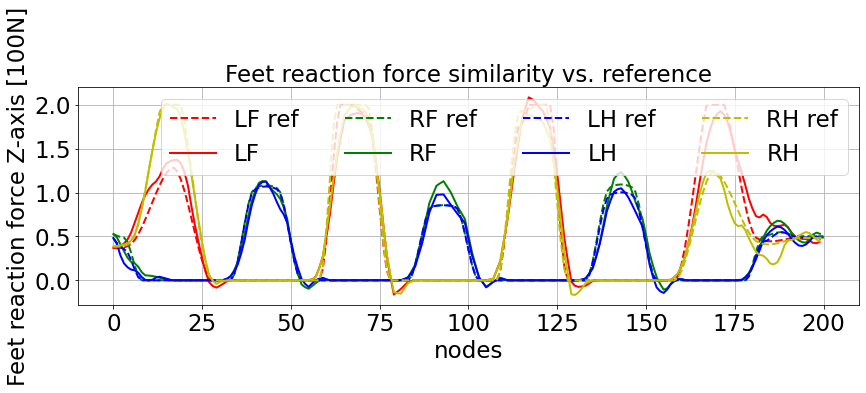

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


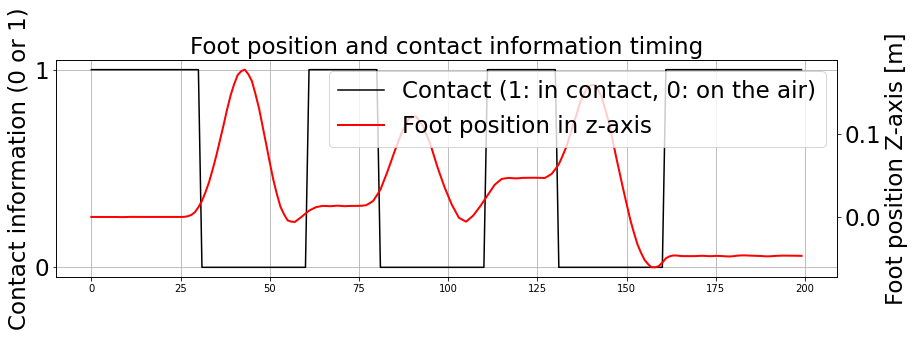

In [20]:
fs = 23 # Common font size
# Base XY plot
fig = plt.figure()
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['font.family'] = 'Times New Roman'
plt.grid()
plt.scatter(Dataset[num,:,0]*100, Dataset[num,:,1]*100, label='Ref Trajectory', color='red')
plt.scatter(motion[index,:,0]*100, motion[index,:,1]*100, label='Pred Trajectory', color='blue')
plt.scatter(Dataset[num,-1,0].cpu()*100, Dataset[num,-1,1].cpu()*100, label='Goal', color='yellow', edgecolor='black', s=200)
plt.legend(loc='upper right', fontsize=fs)
plt.title('Base body trajectory in XY plane', fontsize=fs)
plt.xlabel("X-axis [cm]", fontsize=fs)
plt.ylabel("Y-axis [cm]", fontsize=fs)
plt.xticks(fontsize =fs)
plt.yticks(fontsize =fs)
plt.show()
fig.savefig(PATH+"/data/traj.BaseXY.pdf", bbox_inches='tight')

# Feet position 
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
ax1.grid()
ax1.set_xlabel("nodes", fontsize=fs)
ax1.set_ylabel("Feet position Z-axis [m]", fontsize=fs)
# Left Front
# ax1.set_ylim(-0.05,0.3)
LFpref,=ax1.plot(Dataset[num,:,-26],'--', label='LF ref', color='r', linewidth=2)
LFp,=ax1.plot(motion[0,:,-26],label='LF', color='r', linewidth=2)
# Right Front
RFpref,=ax1.plot(Dataset[num,:,-23],'--', label='RF ref', color='g', linewidth=2)
RFp,=ax1.plot(motion[0,:,-23], label='RF', color='g', linewidth=2)
# Left Hind
LHpref,=ax1.plot(Dataset[num,:,-20],'--', label='LH ref', color='b', linewidth=2)
LHp,=ax1.plot(motion[0,:,-20], label='LH', color='b', linewidth=2)
# Right Hind
RHpref,=ax1.plot(Dataset[num,:,-17],'--', label='RH ref', color='y', linewidth=2)
RHp,=ax1.plot(motion[0,:,-17], label='RH', color='y', linewidth=2)
graphs=[LFpref, LFp, RFpref, RFp, LHpref, LHp, RHpref, RHp]
ax1.legend(graphs, [curve.get_label() for curve in graphs],ncol=4,loc='upper right', fontsize=fs)
plt.title("Feet position similarity vs. reference", fontsize=fs)

plt.xticks(fontsize =fs)
plt.yticks(fontsize =fs)
plt.show()
fig.savefig(PATH+"/data/traj.foot.position.pdf", bbox_inches='tight')

# Reaction force 
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
ax1.grid()
ax1.set_xlabel("nodes", fontsize=fs)
ax1.set_ylabel("Feet reaction force Z-axis [100N]", fontsize=fs)
# ax1.set_ylim(-0.05,3.0)
# Left Front
LFpref,=ax1.plot(Dataset[num,:,-14],'--', label='LF ref', color='r', linewidth=2)
LFp,=ax1.plot(motion[0,:,-14],label='LF', color='r', linewidth=2)
# Right Front
RFpref,=ax1.plot(Dataset[num,:,-11],'--', label='RF ref', color='g', linewidth=2)
RFp,=ax1.plot(motion[0,:,-11], label='RF', color='g', linewidth=2)
# Left Hind
LHpref,=ax1.plot(Dataset[num,:,-8],'--', label='LH ref', color='b', linewidth=2)
LHp,=ax1.plot(motion[0,:,-8], label='LH', color='b', linewidth=2)
# Right Hind
RHpref,=ax1.plot(Dataset[num,:,-5],'--', label='RH ref', color='y', linewidth=2)
RHp,=ax1.plot(motion[0,:,-5], label='RH', color='y', linewidth=2)
graphs=[LFpref, LFp, RFpref, RFp, LHpref, LHp, RHpref, RHp]
ax1.legend(graphs, [curve.get_label() for curve in graphs],ncol=4,loc='upper right', fontsize=fs)
plt.title("Feet reaction force similarity vs. reference", fontsize=fs)
# plt.rcParams["figure.figsize"] = (14,6)
plt.xticks(fontsize =fs)
plt.yticks(fontsize =fs)
plt.show()
fig.savefig(PATH+"/data/traj.foot.reaction.pdf", bbox_inches='tight')

# Contact timing
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# Left Front
ax1.grid()
# ax1.set_ylim(-0.05,1.7)
ax1.set_ylabel("Contact information (0 or 1)", fontsize=fs)
ax1.set_yticks([0, 1])
ax1.set_yticklabels([0, 1],fontsize=fs)
contact,=ax1.plot(cutoff(motion[0,:,-4]), label='Contact (1: in contact, 0: on the air)', color='black')

ax2.set_xlabel("nodes", fontsize=fs)
ax2.set_ylabel("Foot position Z-axis [m]", fontsize=fs)
# ax2.set_ylim(-0.01,0.3)
ax2.tick_params(axis = 'y', labelsize =fs)
LFp,=ax2.plot(motion[0,:,-26],label='Foot position in z-axis', color='r', linewidth=2)

graphs=[contact,LFp]
ax2.legend(graphs, [curve.get_label() for curve in graphs],ncol=1,loc='upper right', fontsize=fs)
plt.title("Foot position and contact information timing", fontsize=fs)
# plt.rcParams["figure.figsize"] = (14,4)
# plt.yticks(fontsize=fs)
plt.show()
fig.savefig(PATH+"/data/traj.foot.timing.pdf", bbox_inches='tight')

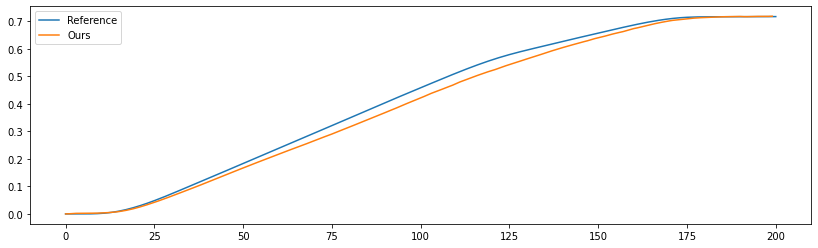

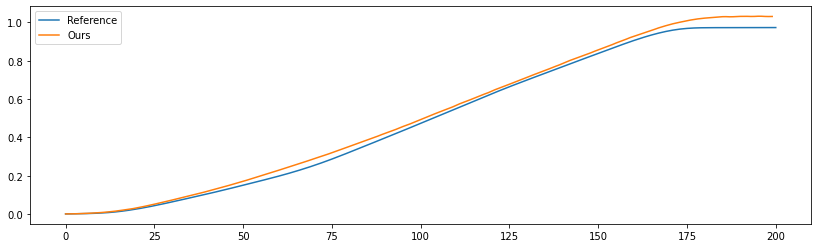

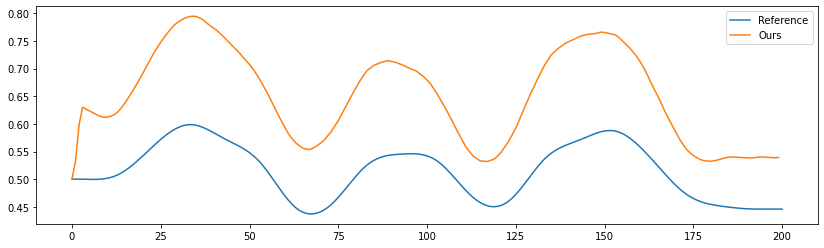

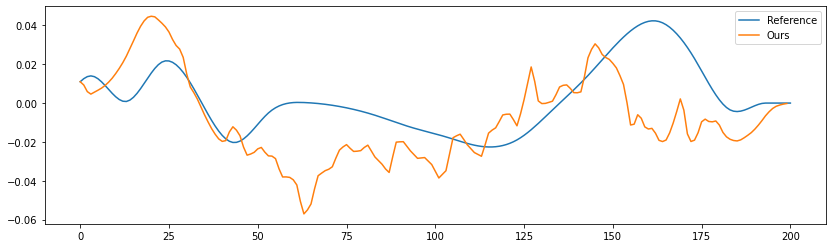

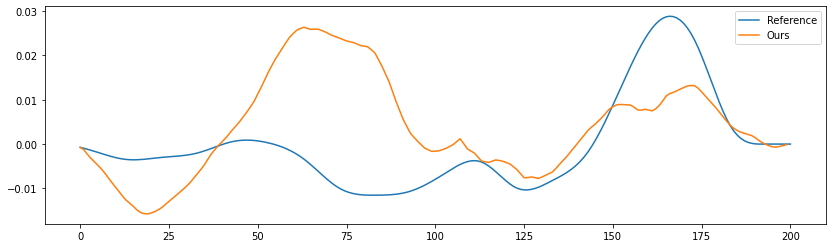

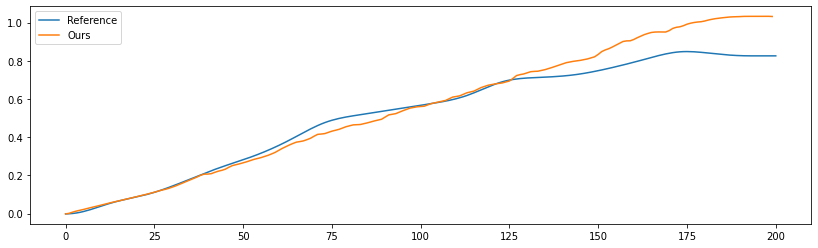

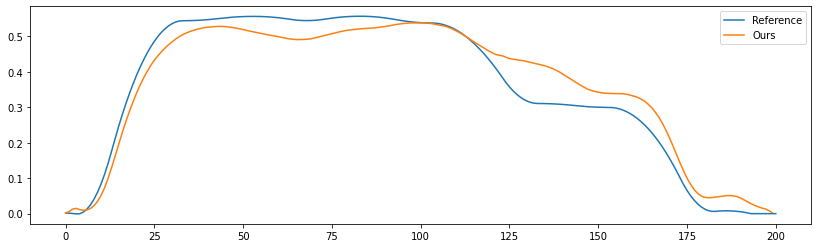

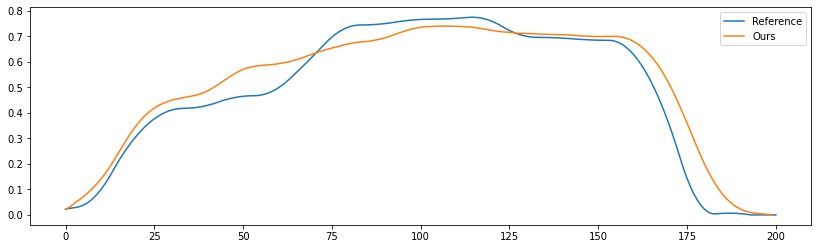

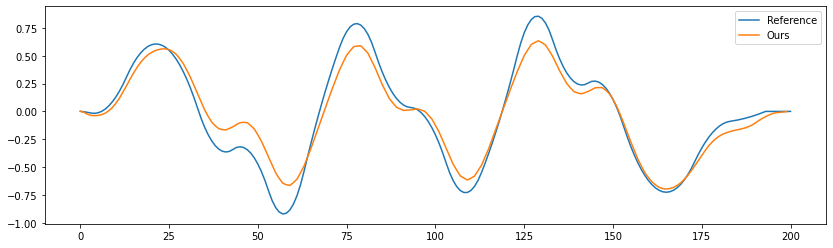

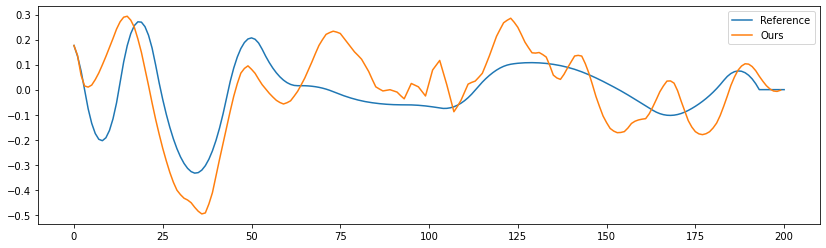

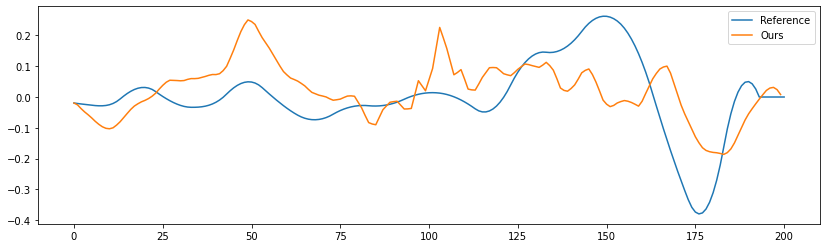

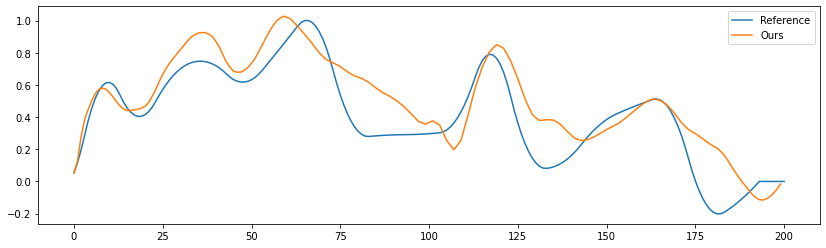

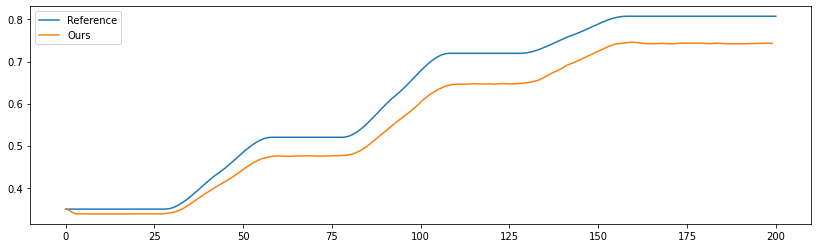

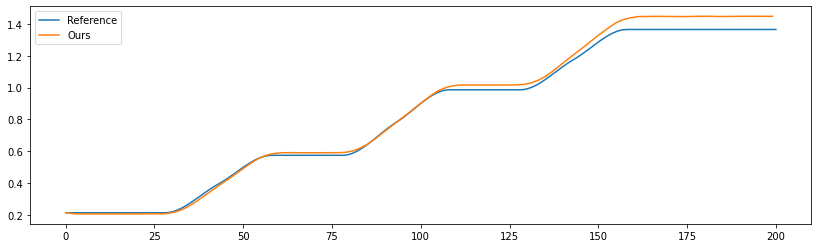

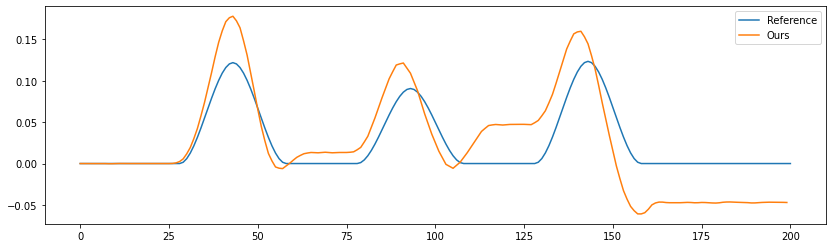

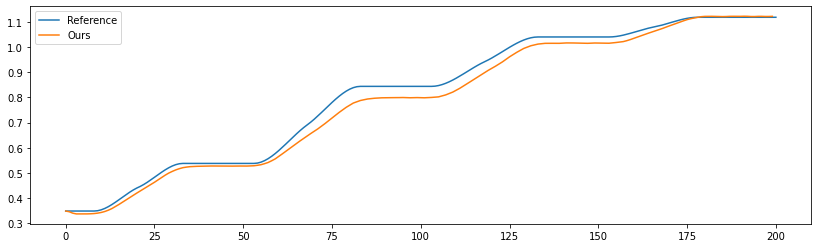

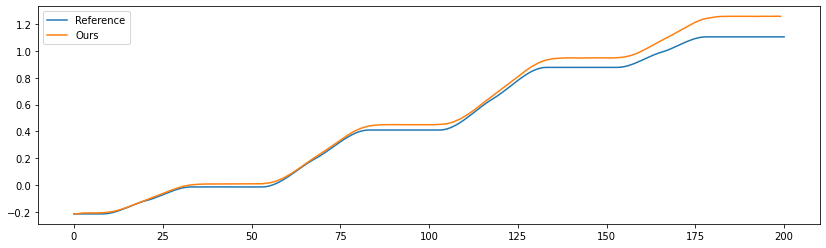

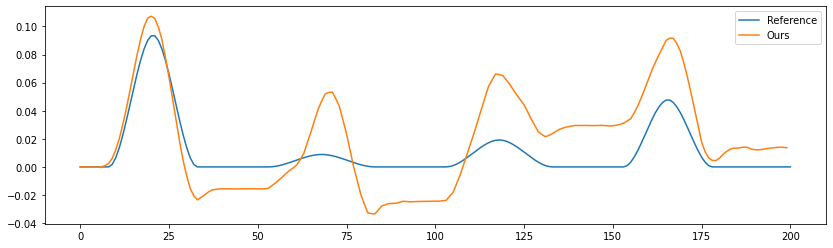

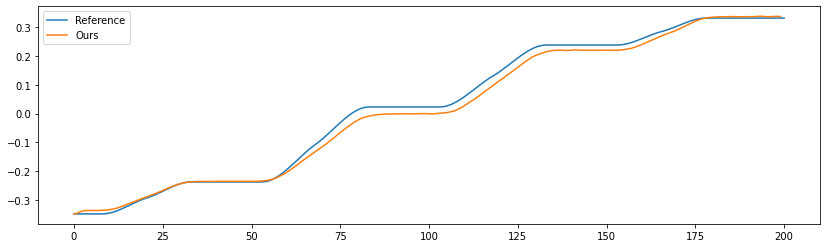

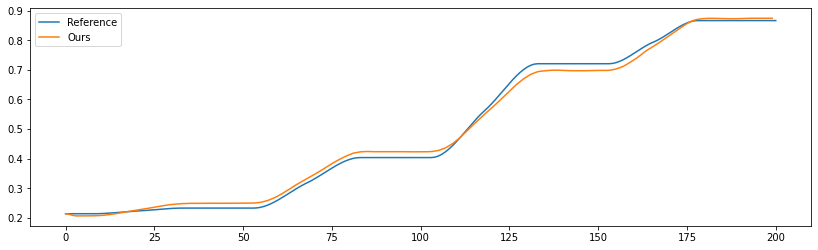

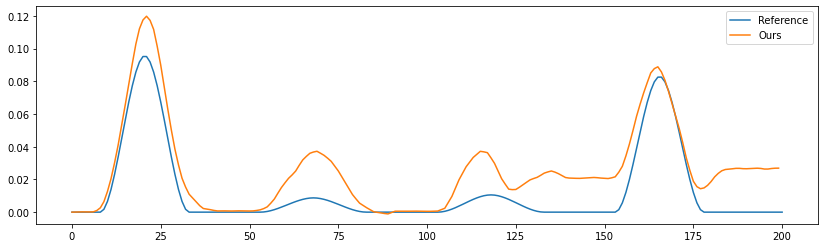

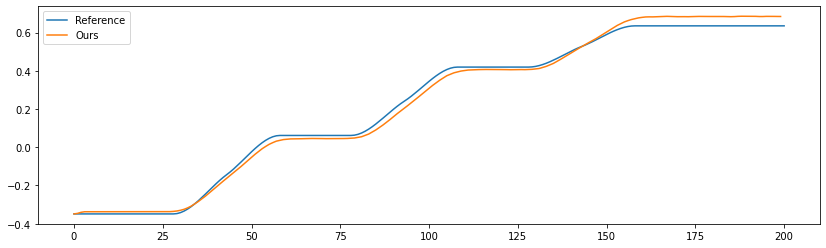

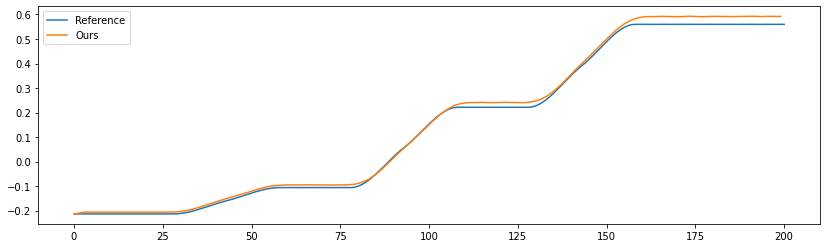

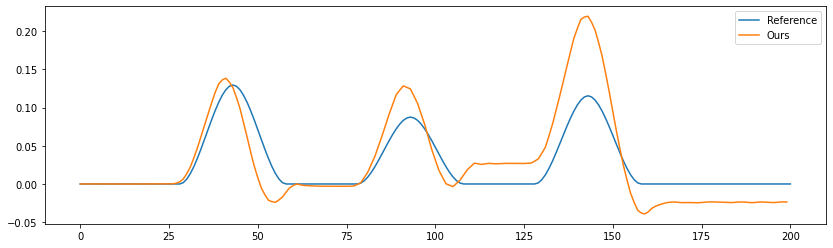

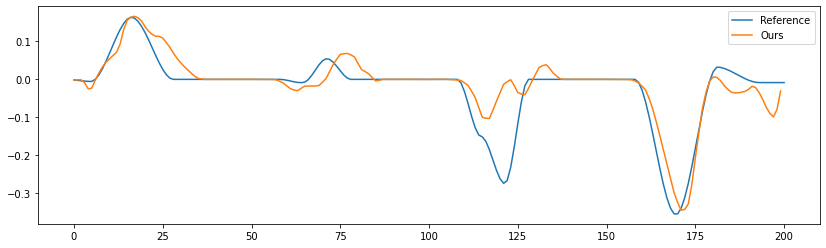

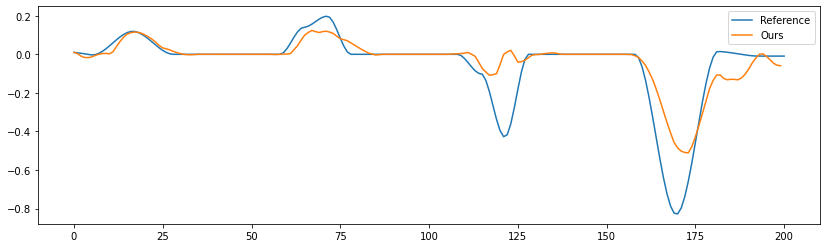

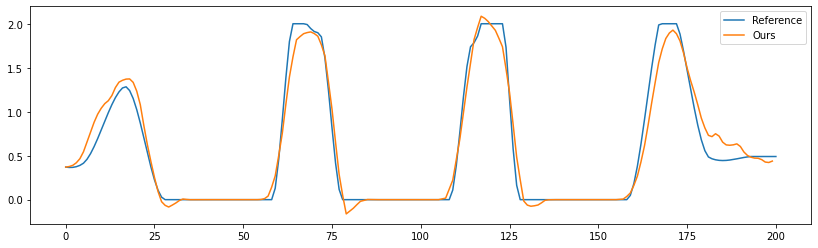

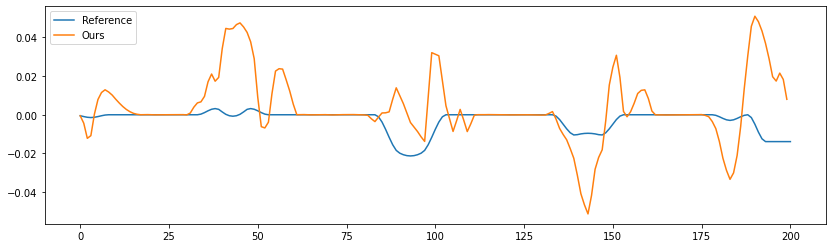

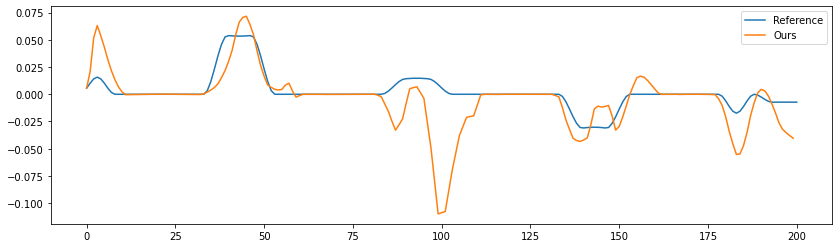

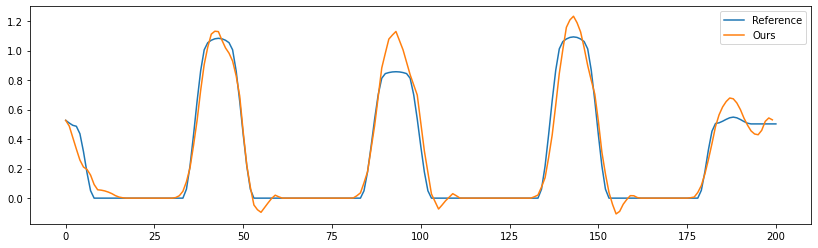

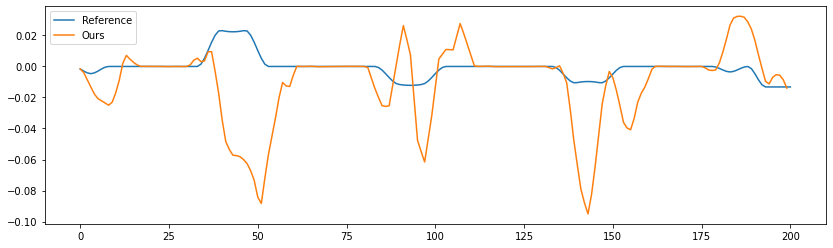

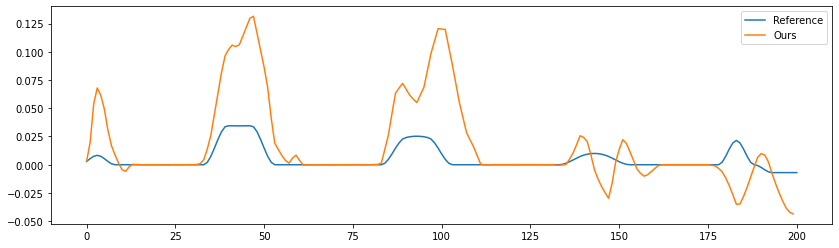

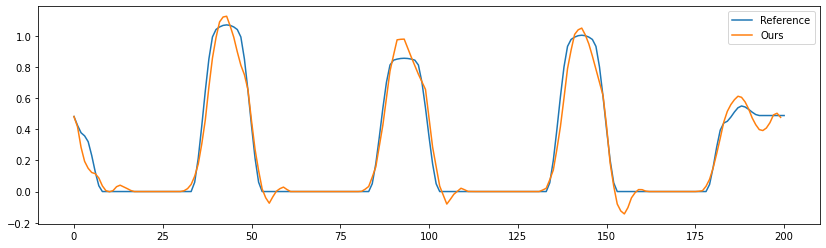

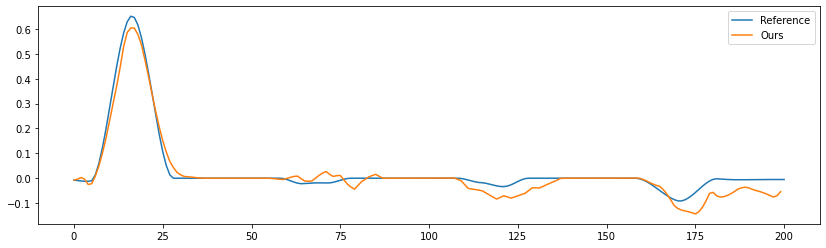

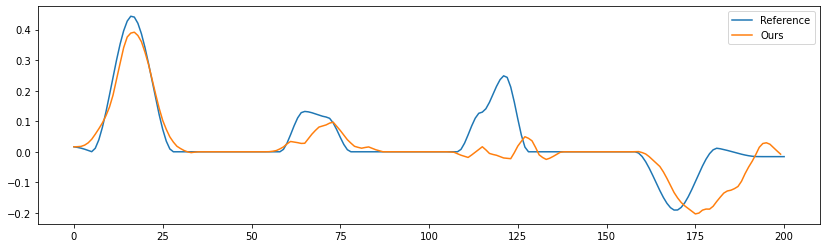

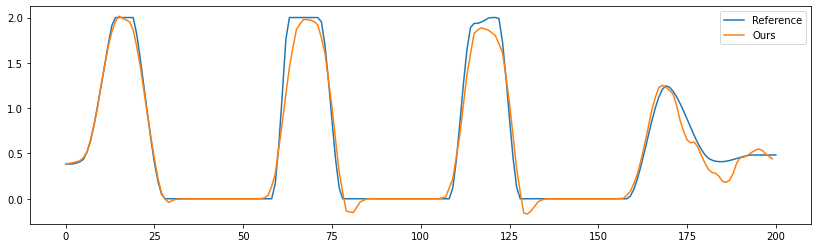

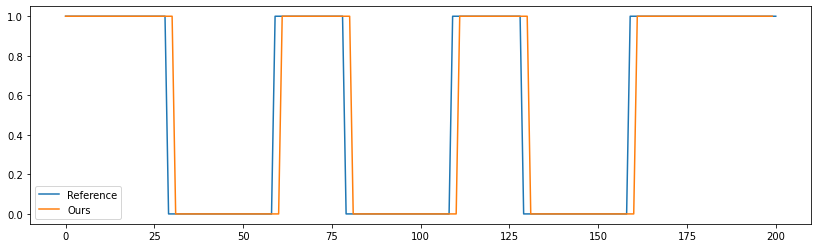

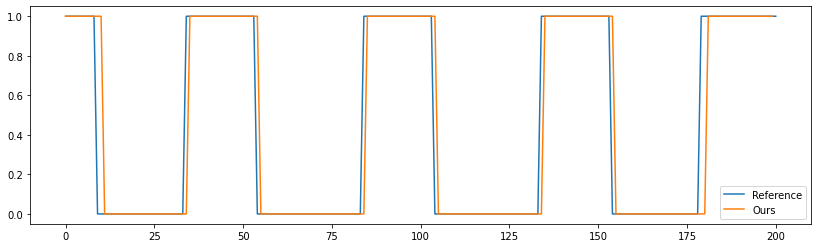

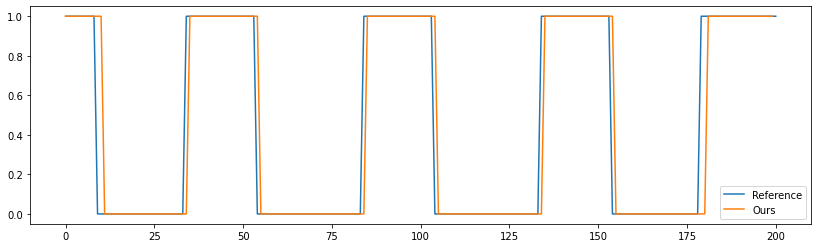

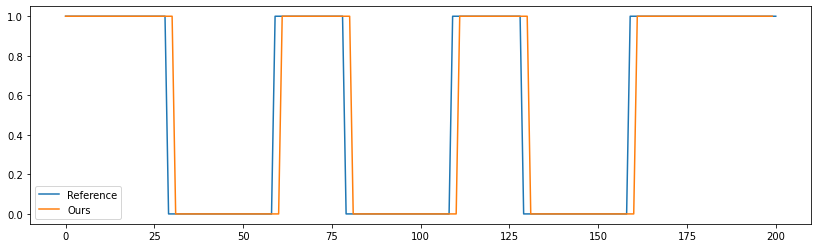

In [21]:
# Plot all domain
for idx in range(Path_dim):
  plt.plot(Dataset[num,:,idx], label='Reference')
  plt.plot(motion[0,:,idx], label='Ours')
  plt.legend()
  plt.show()

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Numerical analysis</h1>

In [22]:
# Import models
params = torch.load(PATH+"/model/QuadNet.tar", map_location = "cpu")
Estimator.load_state_dict(params['model_state_dict'])
Estimator.eval()

# Select dataset (Train/Test)
# numDataset = cp.deepcopy(Paths)
# DatasetT = Terrains
numDataset = cp.deepcopy(Paths_test)
DatasetT = Terrains_test

Init=[1.1778e-03, -1.0302e-03,  5.0001e-01, -4.2223e-03, -4.7900e-04,
      3.8437e-03,  5.9884e-02, -5.2376e-02,  1.3415e-03, -1.6925e-01,
      -3.2622e-02,  1.2686e-01,  3.4900e-01,  2.1350e-01,  0.0000e+00,
      3.4900e-01, -2.1350e-01,  0.0000e+00, -3.4900e-01,  2.1350e-01,
      0.0000e+00, -3.4900e-01, -2.1350e-01,  0.0000e+00,  5.5507e-02,
      -4.6469e-02,  3.9949e-01,  2.9029e-03, -2.4341e-03,  7.0018e-01,
      1.2435e-02, -1.1005e-02,  7.3960e-01,  4.6086e-02, -4.0272e-02,
      3.3032e-01,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]
Init = torch.tensor(Init).view(1,-1).repeat(numDataset.shape[0],1)

# Initial state
States = numDataset[:,0,:].view(-1,Path_dim).type(Tensor)
# Goal base body pose
Goals = numDataset[:,-1,0:6].view(-1,6).type(Tensor)
XnG = torch.cat([States, Goals],dim=1).type(Tensor)
TerrainLatent=DatasetT.view(-1,128).type(Tensor)
motion = Estimator(XnG, TerrainLatent)
motion = motion.cpu().detach()
index=0

# Interpolate
seq_size = (MaxSampleNum-1)//dt
Nodes = cp.deepcopy(motion)
Nodes[:,0] = States
Predict = interNodes(Nodes, motion.shape[0], seq_size)
motion = Predict

#Post processing
motion[:,:,-4:]  = cutoff(motion[:,:,-4:]) 

def distance(pred, target):
  diff = torch.square(pred-target)
  dist = torch.sum(diff, 2)
  return torch.mean(dist)

print("MSE          : ", L2_loss(motion, numDataset).item())
print("RMSE         : ", torch.sqrt(L2_loss(motion, numDataset)).item())
print("base dist(m) : ", distance(motion[:,:,:3], numDataset[:,:,:3]).item())

print("base roll(rad): ", L2_loss(motion[:,:,3], numDataset[:,:,3]).item())
print("base pitch(rad): ", L2_loss(motion[:,:,4], numDataset[:,:,4]).item())
print("base yaw(rad): ", L2_loss(motion[:,:,5], numDataset[:,:,5]).item())

LF=(distance(motion[:,:,12:15], numDataset[:,:,12:15]))
RF=(distance(motion[:,:,15:18], numDataset[:,:,15:18]))
LH=(distance(motion[:,:,18:21], numDataset[:,:,18:21]))
RH=(distance(motion[:,:,21:24], numDataset[:,:,21:24]))
fd=torch.tensor([LF,RF,LH,RH]).mean()
print("Feet dist(m) : ", fd.item())
print("Feet z(m)    : ", L2_loss(motion[:,:,zDomain[:4]], numDataset[:,:,zDomain[:4]]).item())
print("Force z(N): ", L2_loss(motion[:,:,zDomain[4:]], numDataset[:,:,zDomain[4:]]).item())
print("Goal dist    : ", L2_loss(motion[:,-1,0:3], numDataset[:,-1,0:3]).item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


MSE          :  0.047828663140535355
RMSE         :  0.218697652220726
base dist(m) :  0.0252486951649189
base roll(rad):  0.006411902606487274
base pitch(rad):  0.004501353017985821
base yaw(rad):  0.018758291378617287
Feet dist(m) :  0.016288645565509796
Feet z(m)    :  0.0041219694539904594
Force z(N):  0.06399558484554291
Goal dist    :  0.007652652449905872
